In [14]:

import pandas as pd
import numpy as np
from scipy.stats import skew
import warnings
import matplotlib
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet,Lasso, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from tabulate import tabulate
import seaborn as sns
# import xgboost as xgb


warnings.filterwarnings("ignore") 

%matplotlib inline

full_quarter_df=pd.read_csv("new_full_quarterData.csv",header=None)

#Lets read the data
# train =full_quarter_df[20:38]
# test =full_quarter_df.head(20)
train = full_quarter_df.head(20)
test =  full_quarter_df[20:37]
pd.options.display.max_columns = 200  # None -> No Restrictions
pd.options.display.max_rows = 20    # None -> Be careful with this 
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

In [15]:
#Data cleansing

all_data = pd.concat((train,
                      test))

#log transform the target:
# train[5] = np.log1p(train[5])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index  #Lets mark which features are very skewed.

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

# all_data = pd.concat([all_data,pd.get_dummies(all_data['citypair'], prefix='segment')],axis=1)
# all_data = pd.concat([all_data,pd.get_dummies(all_data['aircraft'], prefix='plane')],axis=1)

# all_data.drop(['citypair'],axis=1, inplace=True)
# all_data.drop(['aircraft'],axis=1, inplace=True)

# bigFrame = pd.DataFrame({curr_year,curr_quarter})
# for name, group in all_data_1.groups :
#     print(name)
#     print(group)
#     print(str(year) +"-"+ str(quarter) +", " +citypair + " - "+ aircraft)
#     all_data_1.get_group(quarter, year, citypair, aircraft)
#     if curr_year==year and curr_quarter==quarter:
#         rowFrame=pd.DataFrame({citypair, aircraft,sum_departures_performed,sum_departures_scheduled,passengers,seats})
#         bigFrame=pd.concat(bigFrame,rowFrame)
#     else:
#         curr_year+=1
#         curr_quarter+=1
#         if curr_quarter ==5:
#             curr_quarter=1
#         newBigFrame = pd.DataFrame({curr_year,curr_quarter})
#         bigFrame=bigFrame.append(newBigFrame)
#         rowFrame=pd.DataFrame({citypair, aircraft,sum_departures_performed,sum_departures_scheduled,passengers,seats})
#         bigFrame=pd.concat(bigFrame,rowFrame)

# print(bigFrame)        
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(0)
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train[5]
X_train

,0,1,2,3,4,5,9,10,14,15,19,20,24,25,29,30,34,35,39,40,44,45,49,50,54,55,59,60,64,65,69,70,74,75,79,80,84,85,89,90,94,95,99,100,104,105,109,110,114,115,119,120,124,125,129,130,134,135,139,140,144,145,149,150,154,155,159,160,164,165,169,170,174,175,179,180,184,185,189,190,194,195,199,200,204,205,209,210,214,215,219,220,224,225,229,230,234,235,239,240,...,9768_Boeing B737 Max 800,9771_STL,9772_MSY,9773_Boeing B737 Max 800,9776_SMF,9777_MDW,9778_Boeing B737 Max 800,9781_SAT,9782_PHX,9783_Boeing B737 Max 800,9786_SFO,9787_PHX,9788_Boeing B737 Max 800,9791_CMH,9792_OAK,9793_Boeing 737-800,9796_ROC,9797_TPA,9798_Boeing B737 Max 800,9801_MDW,9802_PVD,9803_Boeing B737 Max 800,9806_SJC,9807_ONT,9808_Boeing B737 Max 800,9811_TPA,9812_BNA,9813_Boeing B737 Max 800,9816_LAX,9817_PHX,9818_Boeing B737 Max 800,9821_OKC,9822_BWI,9823_Boeing B737 Max 800,9826_TPA,9827_MKE,9828_Boeing B737 Max 800,9831_SEA,9832_DEN,9833_Boeing B737 Max 800,9836_SMF,9837_BOI,9838_Boeing B737 Max 800,9841_BWI,9842_ROC,9843_Boeing B737 Max 800,9846_HOU,9847_ECP,9848_Boeing B737 Max 800,9851_BNA,9852_AUS,9853_Boeing B737 Max 800,9856_ATL,9857_MCI,9858_Boeing B737 Max 800,9861_DEN,9862_MKE,9863_Boeing B737 Max 800,9866_OKC,9867_DEN,9868_Boeing B737 Max 800,9871_ALB,9872_BWI,9873_Boeing B737 Max 800,9876_ECP,9877_STL,9878_Boeing B737 Max 800,9881_BWI,9882_CLE,9883_Boeing B737 Max 800,9886_AUS,9887_ATL,9888_Boeing B737 Max 800,9891_BWI,9892_SMF,9893_Boeing B737 Max 800,9896_BNA,9897_MSY,9898_Boeing B737 Max 800,9901_STL,9902_PDX,9903_Boeing B737 Max 800,9906_BOS,9907_HOU,9908_Boeing B737 Max 800,9911_DEN,9912_SLC,9913_Boeing B737 Max 800,9916_DEN,9917_CMH,9918_Boeing B737 Max 800,9921_TUL,9922_HOU,9923_Boeing B737 Max 800,9926_SJC,9927_MDW,9928_Boeing B737 Max 800,9931_PDX,9932_ONT,9933_Boeing B737 Max 800
0,2010.0,1.0,78.81,2.591,-2.576e+06,2.630e+06,1149.0,107530.0,1077.0,11.484,1075.0,94881.0,1082.0,91959.0,988.0,85813.0,966.0,85343.0,694.0,81268.0,816.0,71986.0,651.0,68963.0,560.0,68323.0,6.529,68294.0,651.0,67868.0,661.0,67075.0,656.0,64591.0,701.0,64145.0,674.0,64127.0,619.0,63776.0,598.0,63684.0,695.0,63143.0,669.0,62456.0,668.0,62266.0,651.0,61560.0,623.0,61468.0,708.0,11.026,808.0,11.022,661.0,60988.0,656.0,60139.0,664.0,59598.0,559.0,59339.0,624.0,58453.0,464.0,57770.0,621.0,57093.0,725.0,56869.0,586.0,56350.0,613.0,56182.0,578.0,55728.0,724.0,55470.0,586.0,55401.0,547.0,54424.0,621.0,54363.0,738.0,53869.0,6.299,53776.0,763.0,53712.0,519.0,52712.0,6.295,52026.0,439.0,52009.0,532.0,51682.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2010.0,2.0,77.82,2.628,-2.806e+06,3.168e+06,1230.0,119403.0,1080.0,11.546,1032.0,101422.0,1066.0,100614.0,809.0,96569.0,782.0,92137.0,971.0,90613.0,914.0,88966.0,979.0,87326.0,629.0,72459.0,6.646,70762.0,754.0,70723.0,737.0,69748.0,663.0,69114.0,660.0,68843.0,677.0,67828.0,668.0,67677.0,678.0,67197.0,614.0,67150.0,576.0,66857.0,607.0,65695.0,570.0,65215.0,595.0,64339.0,619.0,11.070,700.0,11.066,710.0,63649.0,714.0,63462.0,643.0,63419.0,702.0,63040.0,612.0,63028.0,603.0,62982.0,626.0,62767.0,616.0,62448.0,522.0,61761.0,581.0,60926.0,602.0,60376.0,624.0,60017.0,573.0,59405.0,633.0,59379.0,626.0,57547.0,722.0,57216.0,6.576,57170.0,597.0,56743.0,537.0,56302.0,6.358,56053.0,504.0,55706.0,521.0,54544.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2010.0,3.0,76.06,2.555,-2.837e+06,3.192e+06,1310.0,126379.0,1043.0,11.522,1052.0,99969.0,815.0,99340.0,990.0,95550.0,959.0,95087.0,754.0,90739.0,790.0,87896.0,910.0,87422.0,861.0,83113.0,6.554,80511.0,623.0,75177.0,733.0,73283.0,679.0,70620.0,676.0,70126.0,719.0,69590.0,695.0,69167.0,629.0,67370.0,646.0,67340.0,652.0,67011.0,645.0,65350.0,533.0,65329.0,657.0,65121.0,562.0,11.072,

In [16]:
X_train.shape

(20, 59804)

In [17]:
def rmse_cv(model, dataset):
    rmse= np.sqrt(-cross_val_score(model, dataset, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def outputPredictionToCSV(predictionData, filename):
    arr = test.loc[:,0]
    arr2 = test.loc[:,1]
#     arr3 = np.expm1(predictionData)
    arr3=predictionData
    df = pd.DataFrame(data=arr, columns = ["Year"])
    df.applymap(int) 
    
    df1 = pd.DataFrame(data=arr2, columns = ["Quarter"])
    df1.applymap(int)
    
    df2 = pd.DataFrame(data=arr3, columns = ['predict.revenue'])
        
    df4 = pd.concat([df,df1,df2], axis=1)
    dff = pd.DataFrame(data=df4) 
    dff.to_csv(filename+".csv", index=False)
    

def printRMSE_MSE(modelName,model,trainData):
    print(modelName +" has RMSE of "+ str(rmse_cv(model,trainData).mean()))
    yHat= model.predict(trainData) 
    print(modelName + " has MSE on train data is: "+ str(mean_squared_error(y,yHat)))
    
def printActuals(predictionData):
    act_data = test
#     print(act_data)
    arr3 = predictionData
    percentErrors =[]
    for x in range(len(act_data.iloc[:,5])):
#     print(act_data.iloc[x,5])
        percentError= (100*(abs(float(act_data.iloc[x,5])-float(arr3[x]))/float(act_data.iloc[x,5])))
        print("Quarter : "+str(act_data.iloc[x,1])+" Year: "+str(act_data.iloc[x,0])+" : Actual: "+str(act_data.iloc[x,5])+" ,Prediction: "+str(arr3[x])+" ,Error: "+ str(percentError)+"%")
        percentErrors.append(percentError)
    print("Avg Percent Error is : "+str(sum(percentErrors) / len(percentErrors) ))
    
    
def printTopTenFeatures(model):
    import operator
    coeff_used = np.sum(model.coef_!=0)
    print("Number of Coeffients used: "+ str(coeff_used))
    coef_dict = {} 

    indexOfFeature =0
    
#     switch (featureLabel) {
#         case 0:
#         case 1:
#         case 2:
#         case 3:
#         case 4:
#         case 5:
#         case :
    for coef in model.coef_:
        if coef!=0: 
            coef_dict[X_train.columns[indexOfFeature]]=coef
        indexOfFeature+=1
    highestCoef_dict_sorted = sorted(coef_dict.items(), key=operator.itemgetter(1), reverse=True)[:5]
    print("Highest Coef: ")
    print(highestCoef_dict_sorted)
    lowestCoef_dict_sorted = sorted(coef_dict.items(), key=operator.itemgetter(1), reverse=False)[:5]
    print("Lowest Coef: ")
    print(lowestCoef_dict_sorted)
            
    

In [18]:
# ridge regression
modelForProblem1= Ridge(alpha=.1).fit(X_train, y)

printRMSE_MSE('ridge_regression_withGivenAlpha',modelForProblem1,X_train)

predictforModel1= modelForProblem1.predict(X_test)
outputPredictionToCSV(predictforModel1,'ridge_regression_withGivenAlpha_output')
print(X_train.shape)
printActuals(predictforModel1)
printTopTenFeatures(modelForProblem1)

ridge_regression_withGivenAlpha has RMSE of 177.47386235081677
ridge_regression_withGivenAlpha has MSE on train data is: 1.3876595185424722e-15
(20, 59804)
Quarter : 1.0 Year: 2015.0 : Actual: 4414000.0 ,Prediction: 4413833.496532263 ,Error: 0.0037721673705656033%
Quarter : 2.0 Year: 2015.0 : Actual: 5111000.0 ,Prediction: 5110914.712678409 ,Error: 0.0016687012637608778%
Quarter : 3.0 Year: 2015.0 : Actual: 5318000.0 ,Prediction: 5317940.122146043 ,Error: 0.0011259468589132164%
Quarter : 4.0 Year: 2015.0 : Actual: 4977000.0 ,Prediction: 4976965.631963313 ,Error: 0.0006905372048899762%
Quarter : 1.0 Year: 2016.0 : Actual: 4826000.0 ,Prediction: 4825908.51659778 ,Error: 0.0018956361835806253%
Quarter : 2.0 Year: 2016.0 : Actual: 5384000.0 ,Prediction: 5383974.230608081 ,Error: 0.00047862912181565565%
Quarter : 3.0 Year: 2016.0 : Actual: 5139000.0 ,Prediction: 5139103.824684842 ,Error: 0.0020203285627857235%
Quarter : 4.0 Year: 2016.0 : Actual: 4940000.0 ,Prediction: 4940082.599847828 ,Er

In [ ]:
# Find the best Alpha for a ridge regression and a lasso regression model.

alphas = [0.000005, 0.00005, 0.00001, 0.0005, 0.0001, 0.005, 0.05, 0.1, 0.3, 0.5, 1, 3, 5, 7, 8, 9,9.5, 10, 10.5, 11, 15, 30, 50, 75, 100]

cv_ridge = [rmse_cv(Ridge(alpha = alpha),X_train).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
print("The best ridge regression : "+str(cv_ridge.min()) +" with Alpha as " + str(cv_ridge.idxmin()))
print("The top five are:\n"+ str(cv_ridge.sort_values().head(5)))



cv_lasso = [rmse_cv(Lasso(alpha = alpha),X_train).mean() 
            for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index = alphas)
print("\n\nThe best lasso regression : " +str(cv_lasso.min()) +" with Alpha as " + str(cv_lasso.idxmin()))
print("The top five are:\n"+ str(cv_lasso.sort_values().head(5)))

bestRidgeRegressionAlphaValue = cv_ridge.idxmin()
bestLassoRegressionAlphaValue = cv_lasso.idxmin()

The best ridge regression : 177.47386223765687 with Alpha as 1e-05
The top five are:
1.000e-05    177.474
5.000e-06    177.474
5.000e-05    177.474
1.000e-04    177.474
5.000e-04    177.474
dtype: float64


In [ ]:
# ridge regression with best alpha
modelForProblem2= Ridge(alpha = bestRidgeRegressionAlphaValue).fit(X_train, y)

printRMSE_MSE('ridge_regression_withBestAlpha',modelForProblem2,X_train)

predictforModel2= modelForProblem2.predict(X_test)
outputPredictionToCSV(predictforModel2,'ridge_regression_WithBestAlpha_output')
printActuals(predictforModel2)
coeff_used = np.sum(modelForProblem2.coef_!=0)
print("Coeffients used: "+ str(coeff_used))
print(modelForProblem2.coef_)

In [ ]:
# Lasso with best alpha
modelForProblem2b= Lasso(alpha = bestLassoRegressionAlphaValue).fit(X_train, y)

printRMSE_MSE('lasso_regression_withBestAlpha',modelForProblem2b,X_train)

predictforModel2b= modelForProblem2b.predict(X_test)
outputPredictionToCSV(predictforModel2b,'lasso_regression_WithBestAlpha_output')
printActuals(predictforModel2b)
coeff_used = np.sum(modelForProblem2b.coef_!=0)
print("Coeffients used: "+ str(coeff_used))
print(modelForProblem2b.coef_)

In [8]:
# l0 norm (number of nonzeros) of the coefficients that lasso produces as you vary the regularization hyperparameter alpha.

# coefDF=[]
# alphaDF=[]

# for x in alphas:
#     temp_lasso= Lasso(alpha = x).fit(X_train, y)
#     coef = pd.Series(temp_lasso.coef_, index = X_train.columns)
#     coefDF.append(sum(coef != 0))
#     alphaDF.append(x)

# dfAlpha =pd.DataFrame(data=alphaDF, columns = ['Alpha'])
# dfCoef =pd.DataFrame(data=coefDF, columns = ['None Zero Coefs'])

# dff2= pd.concat([dfAlpha,dfCoef], axis=1)

# print(dff2.head(10))

# plotThis = pd.DataFrame(data=dff2)
# plotThis.plot()

In [9]:
# ridgeModel= pd.DataFrame(data= modelForProblem2.predict(X_train), columns=["RidgeRevPrice"])
# lassoModel= pd.DataFrame(data= modelForProblem2b.predict(X_train), columns=["LassoRevPrice"])

# ridgeModelTest= pd.DataFrame(data= modelForProblem2.predict(X_test), columns=["RidgeRevPrice"])
# lassoModelTest= pd.DataFrame(data= modelForProblem2b.predict(X_test), columns=["LassoRevPrice"])

# new_X_train=pd.concat([X_train,ridgeModel,lassoModel], axis=1)
# new_X_test=pd.concat([X_test,ridgeModelTest,lassoModelTest], axis=1)

# # print(new_X_train)


# alphas = [0.000005, 0.00005, 0.00001, 0.0005, 0.0001, 0.005, 0.05, 0.1, 0.3, 0.5, 1, 3, 5, 7, 8, 9,9.5, 10, 10.5, 11, 15, 30, 50, 75, 100]

# cv_ridge = [rmse_cv(Ridge(alpha = alpha),new_X_train).mean() 
#             for alpha in alphas]

# cv_ridge = pd.Series(cv_ridge, index = alphas)
# modelForProblem6= Ridge(alpha=cv_ridge.idxmin()).fit(new_X_train, y) 

# printRMSE_MSE('ridge_regression_stacking_output',modelForProblem6,new_X_train)

# predictforModel6 = modelForProblem6.predict(new_X_test)

# outputPredictionToCSV(predictforModel6,'ridge_regression_stacking_output')
# printActuals(predictforModel6)

In [10]:
# Problem 7, I am going to try stacking the previous two with XGB Regression
# I am tried playing around with different HyperParameters for XGB
# My final solution was a serial stack with different varieties of the stack




# rmse_values=[]
# mse_values=[]

# max_depths_values=[]
# n_estimators_values=[]
# reg_alphas_values=[]
# reg_lambdas_values=[]
# learning_rates_values=[]
# colsample_bynodes_values=[]
# subsamples_values=[]

# max_depths = [2,3,4]
# n_estimators =[300, 400,500,600,700]
# reg_alphas = [0.005, 0.05,0.1,0.2, 0.3,0.4, 0.5,0.6,0.7,0.8,0.9, 1, 3, 5, 7, 9, 10, 10.5, 11]
# reg_lambdas = [0.005, 0.05,0.1,0.2, 0.3,0.4, 0.5,0.6,0.7,0.8,0.9, 1, 3, 5, 7, 9, 10, 10.5, 11]
# learning_rates =[0.1,0.2, 0.3,0.4, 0.5,0.6,0.7,0.8,0.9, 1]
# colsample_bynodes = [0.1,0.2, 0.3,0.4, 0.5,0.6,0.7,0.8,0.9, 1]
# subsamples= [0.1, 0.2, 0.3,0.4, 0.5,0.6,0.7,0.8,0.9, 1]
# for max_depth in max_depths:
#     # print('max depth is '+str(max_depth))
#     for n_estimator in n_estimators:
#         # print('estimator is '+str(n_estimator))
#         for reg_alpha in reg_alphas:
#             # print('alpha is '+str(reg_alpha))
#             for lambda_ in reg_lambdas:
#                 # print('lambda is '+str(lambda_))
#                 for learning_rate in learning_rates:
#                     # print('learning rate is '+str(learning_rate))
#                     for colsample_bynode in colsample_bynodes:
#                         # print('colsample is '+str(colsample_bynode))
#                         for subsample in subsamples:
#                             # print('subsample is '+str(subsample))
#                             modelForProblem7 = xgb.XGBRegressor(verbosity=0, max_depth=max_depth, n_estimators=n_estimator,
#                                                                 reg_alpha=reg_alpha, learning_rate=learning_rate, reg_lambda=lambda_,
#                                                                 colsample_bynode=colsample_bynode, subsample=subsample).fit(new_X_train, y)
#                             rmse_values.append(rmse_cv(modelForProblem7,new_X_train).mean())
#                             yHat= modelForProblem7.predict(new_X_train)
#                             mse_values.append(mean_squared_error(y,yHat))
#                             max_depths_values.append(max_depth)
#                             n_estimators_values.append(n_estimator)
#                             reg_alphas_values.append(reg_alpha)
#                             reg_lambdas_values.append(lambda_)
#                             learning_rates_values.append(learning_rate)
#                             colsample_bynodes_values.append(colsample_bynode)
#                             subsamples_values.append(subsample)
#                             print('RMSE is: '+str(rmse_values[-1])+' MSE is '+str(mse_values[-1]))

# dfRMSE =pd.DataFrame(data=rmse_values, columns = ['RMSE'])
# dfMSE =pd.DataFrame(data=mse_values, columns = ['MSE'])
# dfMaxDepth =pd.DataFrame(data=max_depths_values, columns = ['Max Depth'])
# dfEstimator =pd.DataFrame(data=n_estimators_values, columns = ['NEstimators'])
# dfAlphas =pd.DataFrame(data=reg_alphas_values, columns = ['Alpha'])
# dfLambdas =pd.DataFrame(data=reg_lambdas_values, columns = ['Lambda'])
# dfLearningRate =pd.DataFrame(data=learning_rates_values, columns = ['Learning Rate'])
# dfColSample =pd.DataFrame(data=colsample_bynodes_values, columns = ['ColSample'])
# dfSubSample =pd.DataFrame(data=subsamples_values, columns = ['SubSample'])
# bigdf =pd.concat([dfRMSE,dfMSE,dfMaxDepth,dfEstimator,dfAlphas,dfLambdas,dfLearningRate,dfColSample,dfSubSample], axis=1)

# bigdf.to_csv("tuneXGB.csv", index=False)

In [11]:

# modelForProblem7a= RidgeCV().fit(X_train, y)
# dataFromRidge_train= pd.DataFrame(data= modelForProblem7a.predict(X_train), columns=["RidgeSalePrice"])
# dataFromRidge_test= pd.DataFrame(data= modelForProblem7a.predict(X_test), columns=["RidgeSalePrice"])
# a_X_train=pd.concat([X_train,dataFromRidge_train], axis=1)
# a_X_test=pd.concat([X_test,dataFromRidge_test], axis=1)
# printActuals(modelForProblem7a)

# modelForProblem7b= LassoCV().fit(a_X_train, y)
# dataFromLasso_train= pd.DataFrame(data= modelForProblem7b.predict(a_X_train), columns=["LassoSalePrice"])
# dataFromLasso_test= pd.DataFrame(data= modelForProblem7b.predict(a_X_test), columns=["LassoSalePrice"])
# printActuals(modelForProblem7b)

# b_X_train=pd.concat([X_train,dataFromLasso_train], axis=1)
# b_X_test=pd.concat([X_test,dataFromLasso_test], axis=1)

# printRMSE_MSE('serialStack_output',modelForProblem7b,b_X_train)

# predictforModel7b= modelForProblem7b.predict(b_X_test)
# outputPredictionToCSV(predictforModel7b,'serialStack_output')

# c_X_train=pd.concat([X_train,dataFromRidge_train,dataFromLasso_train], axis=1)
# c_X_test=pd.concat([X_test,dataFromRidge_test,dataFromLasso_test], axis=1)
# #with A dataset

# modelForProblem7WithLowValues_a = xgb.XGBRegressor(verbosity=0, max_depth=2,
#                                                  n_estimators=400, reg_alpha=10,
#                                                  learning_rate=.05,colsample_bynode=0.7, 
#                                                  subsample=0.85, reg_lambda=0.85).fit(a_X_train, y)
# printRMSE_MSE('xgb_output_a',modelForProblem7WithLowValues_a,a_X_train)

# predictforModel7WithLowestValue_a = modelForProblem7WithLowValues_a.predict(a_X_test)

# outputPredictionToCSV(predictforModel7WithLowestValue_a,'xgb_output_a')
# printActuals(predictforModel7WithLowestValue_a)

# # with B dataset

# modelForProblem7WithLowValues_b = xgb.XGBRegressor(verbosity=0, max_depth=2,
#                                                  n_estimators=400, reg_alpha=10,
#                                                  learning_rate=.05,colsample_bynode=0.7, 
#                                                  subsample=0.85, reg_lambda=0.85 ).fit(b_X_train, y)

# printRMSE_MSE('xgb_output_b',modelForProblem7WithLowValues_b,b_X_train)

# predictforModel7WithLowestValue_b = modelForProblem7WithLowValues_b.predict(b_X_test)

# outputPredictionToCSV(predictforModel7WithLowestValue_b,'xgb_output_b')

# printActuals(predictforModel7WithLowestValue_b)


# #with AB combined

# modelForProblem7WithLowValues_c = xgb.XGBRegressor(verbosity=0).fit(c_X_train, y)

# printRMSE_MSE('xgb_output_c',modelForProblem7WithLowValues_c,c_X_train)

# predictforModel7WithLowestValue_c = modelForProblem7WithLowValues_c.predict(c_X_test)

# outputPredictionToCSV(predictforModel7WithLowestValue_c,'xgb_output_c')

# printActuals(predictforModel7WithLowestValue_c)

# xgb_train= pd.DataFrame(data= modelForProblem7WithLowValues_c.predict(c_X_train), columns=["XGBSalePrice"])
# xgb_test= pd.DataFrame(data= modelForProblem7WithLowValues_c.predict(c_X_test), columns=["XGBSalePrice"])


# d_X_train=pd.concat([X_train,xgb_train], axis=1)
# d_X_test=pd.concat([X_test,xgb_test], axis=1)

# modelForProblem7d= ElasticNetCV().fit(d_X_train, y)

# printRMSE_MSE('xgb_output_d',modelForProblem7d,d_X_train)

# predictforModel7WithLowestValue_d = modelForProblem7d.predict(d_X_test)

# outputPredictionToCSV(predictforModel7WithLowestValue_d,'final_output')

# printActuals(modelForProblem7d)

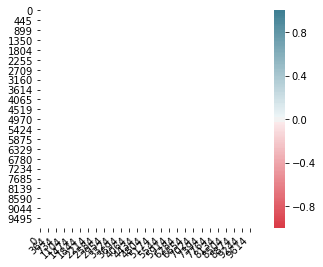

In [12]:
corr = train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(10, 220, sep=5, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);